Embedding method: Average the embeddings of each sentence in a reponse.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import random
from scipy.linalg.interpolative import interp_decomp
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

# Load survey data

In [2]:
# Read it in
path = "../data/surveys_clean_filtered.csv"
df = pd.read_csv(path, na_filter=False)

# Drop rows missing info
df = df[
    (df['long'] != ' ') &
    (df['long'] != '') &
    (df['long'].notnull()) &
    (df['long'] != 0)
]

<br><br>

# Look at responses, not filtered

In [3]:
res_black = df[df['racial_group'] == 'black']['long'].tolist()
res_white = df[df['racial_group'] == 'white']['long'].tolist()
res = res_black + res_white

## Embed responses

In [5]:
res_black_split = [nltk.sent_tokenize(r) for r in res_black]

embed_black = np.transpose([
    np.sum(model.encode(r), axis=0) / len(r)
    for r in res_black_split
])

res_white_split = [nltk.sent_tokenize(r) for r in res_white]

embed_white = np.transpose([
    np.sum(model.encode(r), axis=0) / len(r)
    for r in res_white_split
])

embed = np.concatenate((embed_black, embed_white), axis=1)

## Plot singular values

In [6]:
def plot_singular_values(matrices, title, legend):
    for A in matrices:
        U,S,Vt = np.linalg.svd(A, full_matrices=False)
        S = [s/S[0] for s in S]
        plt.semilogy(S)
    plt.title(title)
    plt.legend(legend)

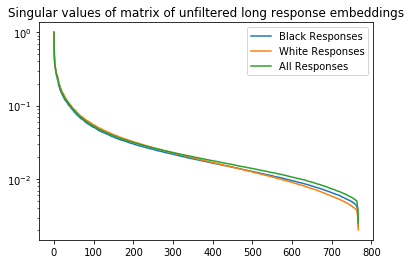

In [7]:
plot_singular_values(
    [embed_black, embed_white, embed],
    "Singular values of matrix of unfiltered long response embeddings",
    ["Black Responses", "White Responses", "All Responses"]
)

## Interpolative Decomposition

In [28]:
methods = ["DEIM", "QR", "random"]

# Modified CUR which only selects columns.
# Does not compute the U or R
def cur(A, idx=False, SVD=None, rank=None, p_C=None, method="DEIM"):
    
    if SVD==None:
        SVD = np.linalg.svd(A, full_matrices=False)
    if rank==None:
        rank = np.linalg.matrix_rank(A)
    
    V,S,Wt = SVD
    
    def DEIM(M, rank, p=None):
        if not p:
            p = []
            p.append(np.argmax(np.abs(M[:,0])))
        for i in range(len(p),rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p
    
    if method == "DEIM":
        p_C = DEIM(np.transpose(Wt), rank, p_C)
    elif method == "QR":
        p_C = interp_decomp(A.astype(np.float64), rank)[0][:rank]
    elif method == "random":
        p_C = random.sample(range(np.shape(Wt)[1]), rank)
    
    C = A[:,p_C]
    
    return (C,p_C) if idx else C

In [30]:
# Using DEIM
C_black_DEIM, p_C_black_DEIM = cur(embed_black, idx=True, method="DEIM")
C_white_DEIM, p_C_white_DEIM = cur(embed_white, idx=True, method="DEIM")
C_DEIM, p_C_DEIM = cur(embed, idx=True, method="DEIM")

# Using QR
C_black_QR, p_C_black_QR = cur(embed_black, idx=True, method="QR")
C_white_QR, p_C_white_QR = cur(embed_white, idx=True, method="QR")
C_QR, p_C_QR = cur(embed, idx=True, method="QR")

# Using random
C_black_random, p_C_black_random = cur(embed_black, idx=True, method="random")
C_white_random, p_C_white_random = cur(embed_white, idx=True, method="random")
C_random, p_C_random = cur(embed, idx=True, method="random")

## Do any of the interpolative methods show a bias toward responses with more sentences?

In [31]:
def plot_sentence_counts(ax, res, p_C, title):
    lengths = [len(nltk.sent_tokenize(res[i])) for i in p_C[:100]]
    ax.hist(lengths, bins=np.arange(1,max(lengths)+2))
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)
    ax.set_title(title)

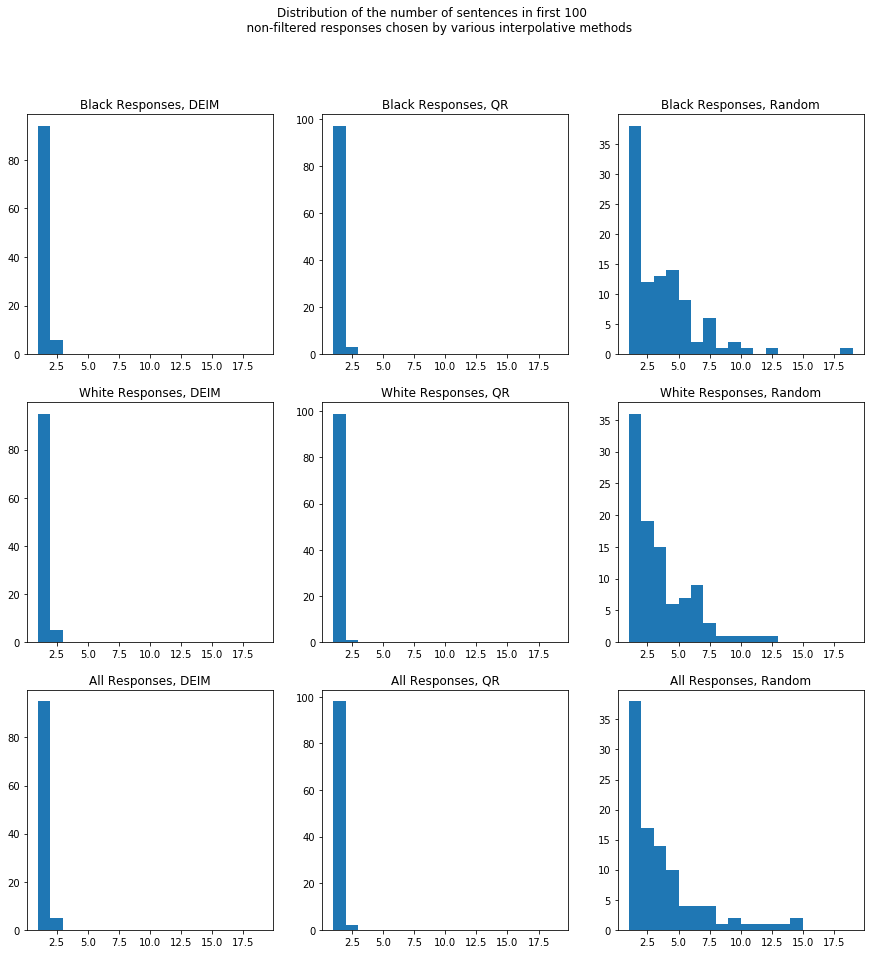

In [32]:
fig, axs = plt.subplots(3,3, sharex=True, figsize=(15,15))
fig.suptitle(
    """Distribution of the number of sentences in first 100
    non-filtered responses chosen by various interpolative methods"""
)

# Black
plot_sentence_counts(axs[0][0], res_black, p_C_black_DEIM, "Black Responses, DEIM")
plot_sentence_counts(axs[0][1], res_black, p_C_black_QR, "Black Responses, QR")
plot_sentence_counts(axs[0][2], res_black, p_C_black_random, "Black Responses, Random")

# White
plot_sentence_counts(axs[1][0], res_white, p_C_white_DEIM, "White Responses, DEIM")
plot_sentence_counts(axs[1][1], res_white, p_C_white_QR, "White Responses, QR")
plot_sentence_counts(axs[1][2], res_white, p_C_white_random, "White Responses, Random")

# All
plot_sentence_counts(axs[2][0], res, p_C_DEIM, "All Responses, DEIM")
plot_sentence_counts(axs[2][1], res, p_C_QR, "All Responses, QR")
plot_sentence_counts(axs[2][2], res, p_C_random, "All Responses, Random")

## Error plots

In [33]:
def get_error(A, method):
    V,S,Wt = np.linalg.svd(A, full_matrices=False)
    rank = np.linalg.matrix_rank(A)
    print("Rank:", rank)
    
    eta_c = np.zeros(rank)
    norm = np.zeros(rank)
    sig = np.zeros(rank)
    
    p_C_k = [] # track any pre-selected columns
    
    A_k = np.zeros(A.shape)
    for k in range(rank):
        SVD_k = (V[:,:k+1], S[:k+1], Wt[:k+1,:])
        A_k = (SVD_k[0] * SVD_k[1][...,None,:] @ SVD_k[2])
        C_k, p_C_k = cur(A, idx=True, SVD=(V,S,Wt), rank=k+1, p_C=p_C_k, method=method)
        WtF_k = SVD_k[2][:k+1,:][:,p_C_k[:k+1]]        
        eta_c[k] = np.linalg.norm(np.linalg.inv(WtF_k))
        X_k = np.linalg.pinv(C_k) @ A
        norm[k] = np.linalg.norm(A - C_k@X_k)
        sig[k] = np.linalg.norm(A - A_k)
        
        if k%100==0:
            print("Progress:",k,"/",rank)
            
    return eta_c, sig, norm, rank

In [34]:
# https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

In [35]:
def plot_errors(errors, title):
    fig = plt.figure(figsize=(5*len(methods),10))
    fig.suptitle("Error, "+title)
    
    axs = []
    for i in range(0,len(methods)*2,2):
        sharey = None if i == 0 else axs[0][1]
        axs.append([
            fig.add_subplot(len(methods), 2, i+1),
            fig.add_subplot(len(methods), 2, i+2, sharey=sharey)
        ])
    
    for i in range(len(methods)):
        eta_c, sig, norm, rank = errors[i]
        
        #in_range = eta_c <= max(sig) # filter things that mess up scaling
        #axs[i][0].scatter(np.array(range(rank))[in_range], np.array(eta_c)[in_range])
        axs[i][0].scatter(range(rank), eta_c)
        axs[i][0].scatter(range(rank), norm)
        axs[i][0].scatter(range(1,rank+1), sig)
        axs[i][0].set(xlabel='k')
        axs[i][0].legend(["(eta_c)_k", "|| A - C_k(X_k) ||", "sigma_k"])
        axs[i][0].set_title(methods[i])

        out_range = is_outlier(norm/sig) # filter things that mess up scaling
        #axs[i][1].scatter(range(100), (norm[:100]-sig[:100])/sig[:100])
        axs[i][1].scatter(np.array(range(rank))[~out_range], np.array(norm/sig)[~out_range])
        axs[i][1].set(xlabel='k')
        axs[i][1].legend(["|| A - C_k(X_k) || / sigma_(k+1)"])
        axs[i][1].set_title(methods[i])
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


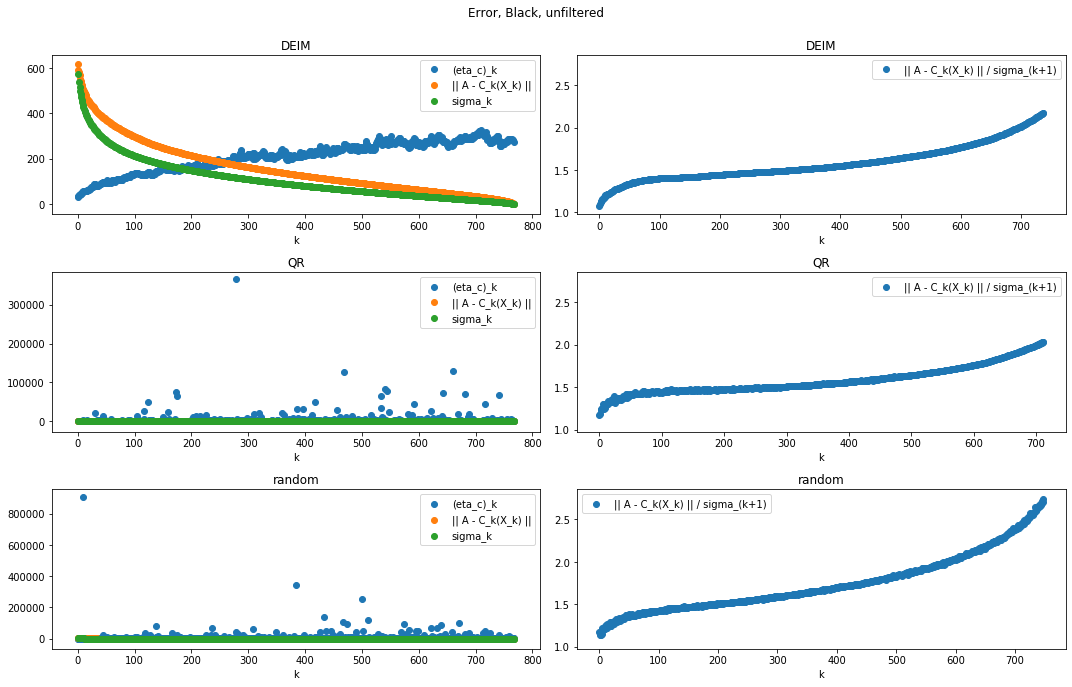

In [36]:
errors_black = [get_error(embed_black,m) for m in methods]
plot_errors(errors_black, "Black, unfiltered")

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


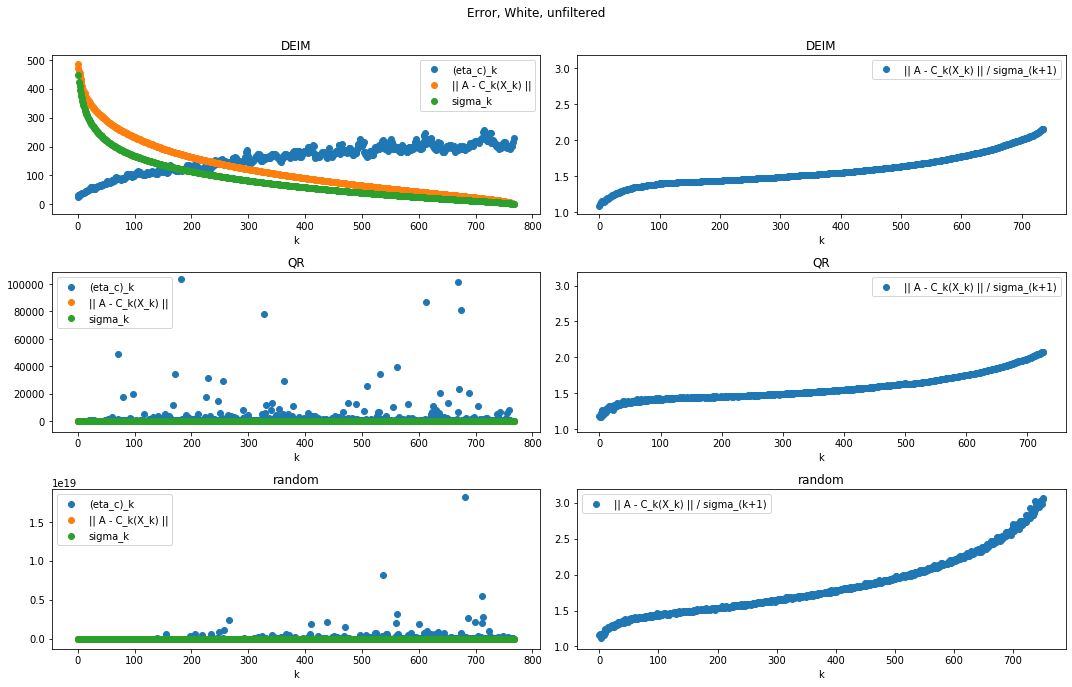

In [37]:
#errors_white = [get_error(embed_white,m) for m in methods]
errors_white[1] = get_error(embed_white,"QR")
plot_errors(errors_white, "White, unfiltered")

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


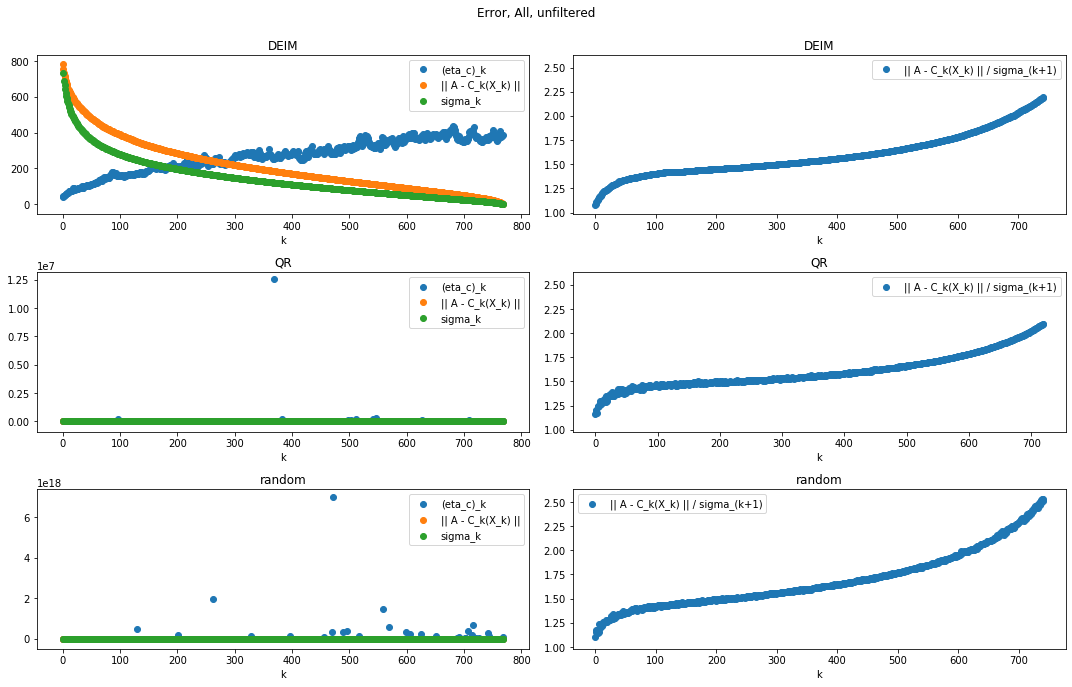

In [38]:
#errors = [get_error(embed,m) for m in methods]
errors[1] = get_error(embed,"QR")
plot_errors(errors, "All, unfiltered")

<br><br>

# Look at responses, filtered by discussion of race

In [20]:
res_black_fil = df[(df['about_race'] > 0) & (df['racial_group'] == 'black')]['long'].tolist()
res_white_fil = df[(df['about_race'] > 0) & (df['racial_group'] == 'white')]['long'].tolist()
res_fil = res_black_fil + res_white_fil

## Embed responses

In [21]:
res_black_fil_split = [nltk.sent_tokenize(r) for r in res_black_fil]

embed_black_fil = np.transpose([
    np.sum(model.encode(r), axis=0) / len(r)
    for r in res_black_fil_split
])

res_white_fil_split = [nltk.sent_tokenize(r) for r in res_white_fil]

embed_white_fil = np.transpose([
    np.sum(model.encode(r), axis=0) / len(r)
    for r in res_white_fil_split
])

embed_fil = np.concatenate((embed_black_fil, embed_white_fil), axis=1)

## Plot singular values

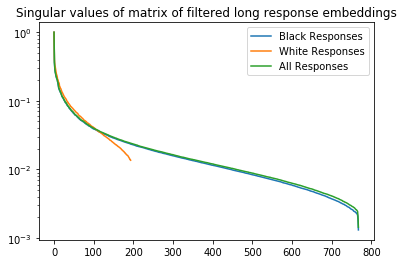

In [22]:
plot_singular_values(
    [embed_black_fil, embed_white_fil, embed_fil],
    "Singular values of matrix of filtered long response embeddings",
    ["Black Responses", "White Responses", "All Responses"]
)

## Interpolative Decomposition

In [39]:
# Using DEIM
C_black_DEIM_fil, p_C_black_DEIM_fil = cur(embed_black_fil, idx=True, method="DEIM")
C_white_DEIM_fil, p_C_white_DEIM_fil = cur(embed_white_fil, idx=True, method="DEIM")
C_DEIM_fil, p_C_DEIM_fil = cur(embed_fil, idx=True, method="DEIM")

# Using QR
C_black_QR_fil, p_C_black_QR_fil = cur(embed_black_fil, idx=True, method="QR")
C_white_QR_fil, p_C_white_QR_fil = cur(embed_white_fil, idx=True, method="QR")
C_QR_fil, p_C_QR_fil = cur(embed_fil, idx=True, method="QR")

# Using random
C_black_random_fil, p_C_black_random_fil = cur(embed_black_fil, idx=True, method="random")
C_white_random_fil, p_C_white_random_fil = cur(embed_white_fil, idx=True, method="random")
C_random_fil, p_C_random_fil = cur(embed_fil, idx=True, method="random")

## Do any of the interpolative methods show a bias toward responses with more sentences?

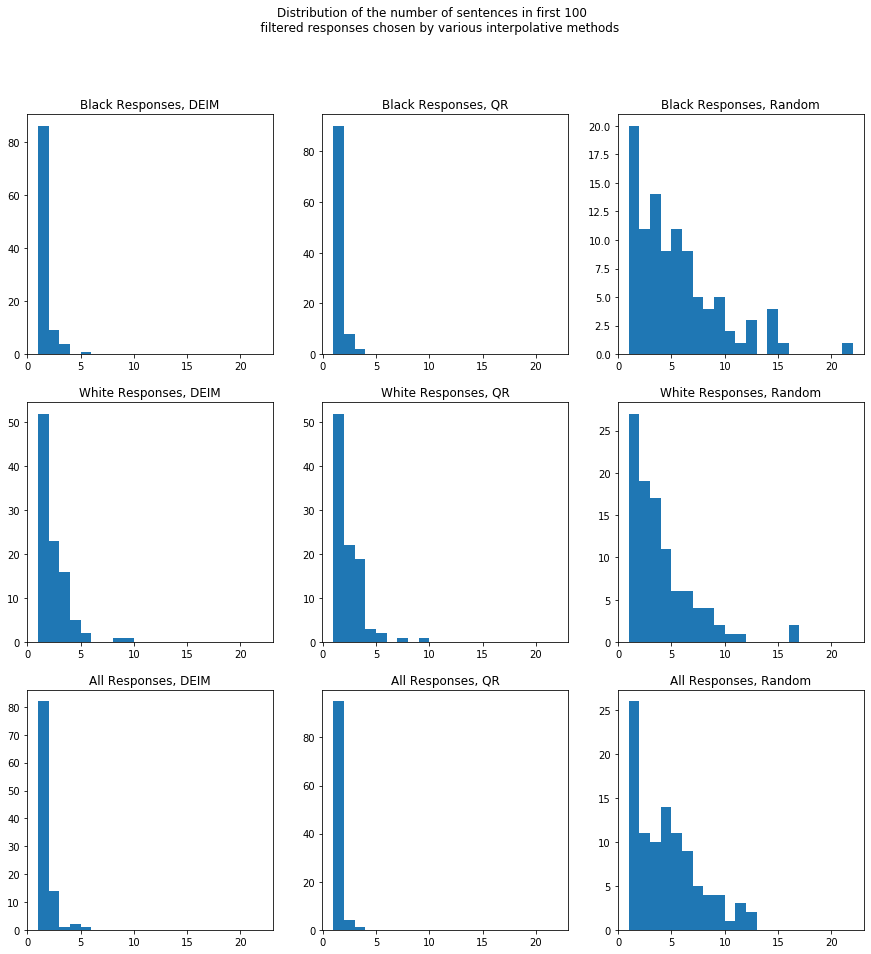

In [40]:
fig, axs = plt.subplots(3,3, sharex=True, figsize=(15,15))
fig.suptitle(
    """Distribution of the number of sentences in first 100
    filtered responses chosen by various interpolative methods"""
)

# Black
plot_sentence_counts(axs[0][0], res_black_fil, p_C_black_DEIM_fil, "Black Responses, DEIM")
plot_sentence_counts(axs[0][1], res_black_fil, p_C_black_QR_fil, "Black Responses, QR")
plot_sentence_counts(axs[0][2], res_black_fil, p_C_black_random_fil, "Black Responses, Random")

# White
plot_sentence_counts(axs[1][0], res_white_fil, p_C_white_DEIM_fil, "White Responses, DEIM")
plot_sentence_counts(axs[1][1], res_white_fil, p_C_white_QR_fil, "White Responses, QR")
plot_sentence_counts(axs[1][2], res_white_fil, p_C_white_random_fil, "White Responses, Random")

# All
plot_sentence_counts(axs[2][0], res_fil, p_C_DEIM_fil, "All Responses, DEIM")
plot_sentence_counts(axs[2][1], res_fil, p_C_QR_fil, "All Responses, QR")
plot_sentence_counts(axs[2][2], res_fil, p_C_random_fil, "All Responses, Random")

## Error plots

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


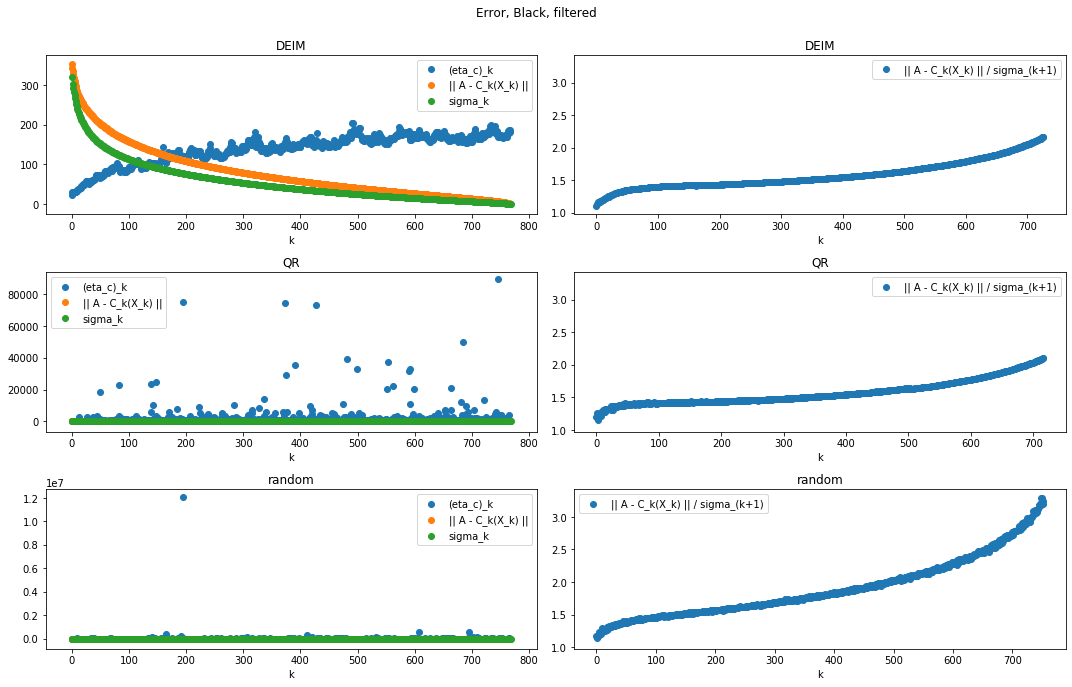

In [41]:
#errors_black_fil = [get_error(embed_black_fil,m) for m in methods]
errors_black_fil[1] = get_error(embed_black_fil,"QR")
plot_errors(errors_black_fil, "Black, filtered")

Rank: 194
Progress: 0 / 194
Progress: 100 / 194


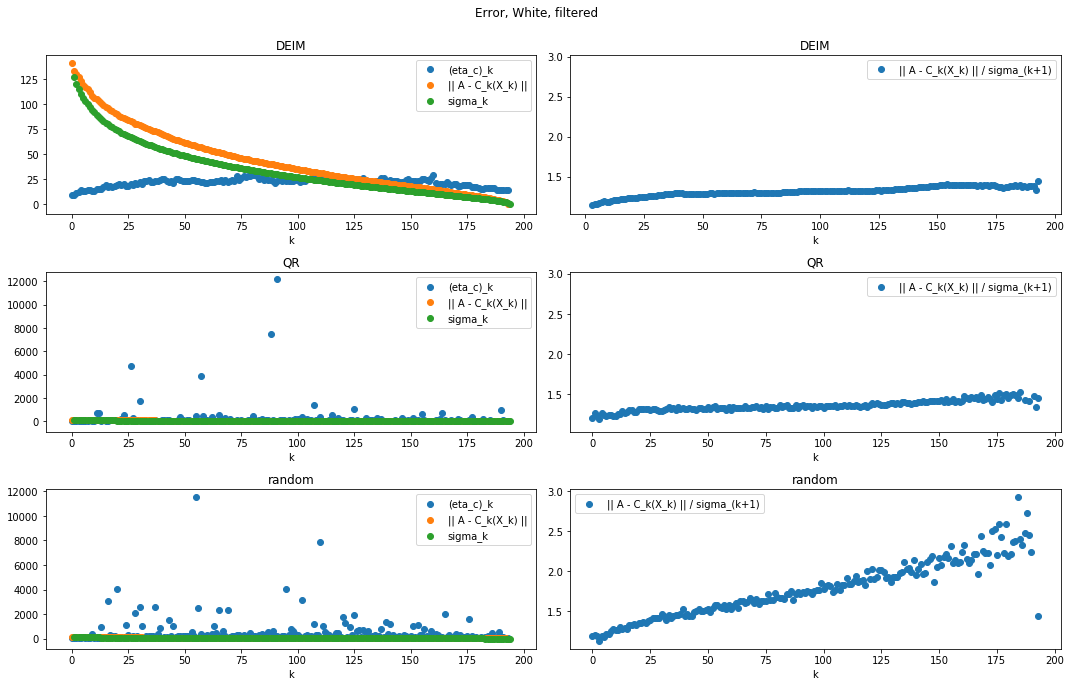

In [42]:
#errors_white_fil = [get_error(embed_white_fil,m) for m in methods]
errors_white_fil[1] = get_error(embed_white_fil,"QR")
plot_errors(errors_white_fil, "White, filtered")

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


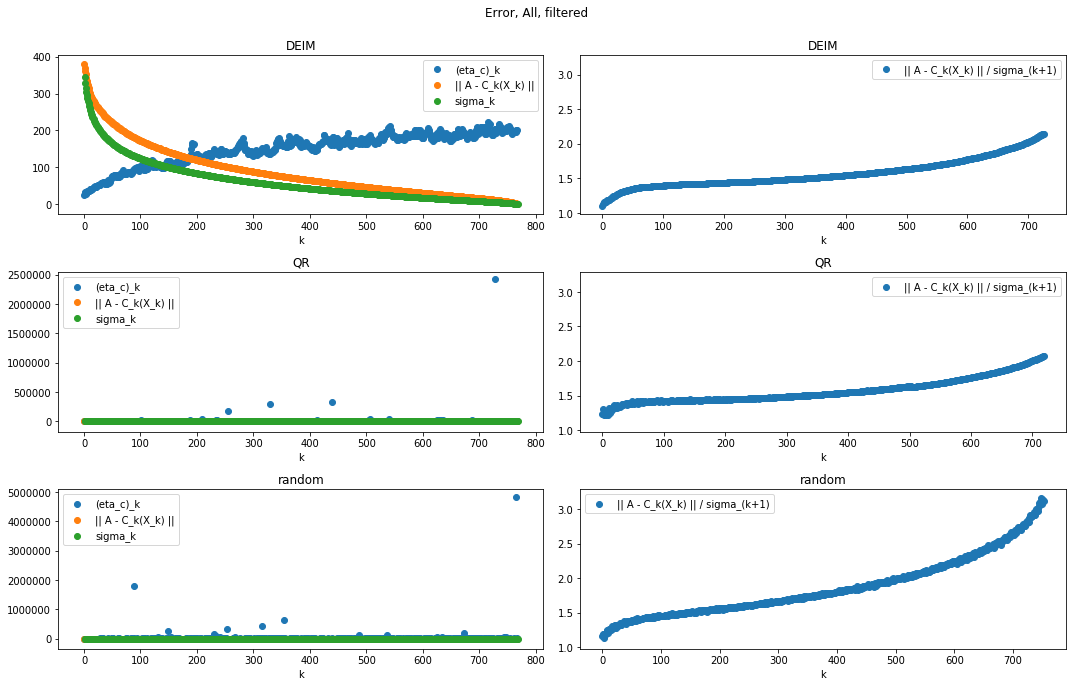

In [43]:
#errors_fil = [get_error(embed_fil,m) for m in methods]
errors_fil[1] = get_error(embed_fil,"QR")
plot_errors(errors_fil, "All, filtered")